# Find N-termini that are (de)stabilized by UBR1 KO

jyelland

## Procedure

1. Clean data from [Timms et al](https://pubmed.ncbi.nlm.nih.gov/31273098/).

## Load libraries

In [1]:
library(org.Hs.eg.db)
library(tidyverse)
library(readxl)
library(rasilabRtemplates)
library(ggrepel)
library(ggpubr)

Loading required package: AnnotationDbi

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: Biobase

Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.


Loading required package: IRanges

Loading required package: S4Vectors

## Load data

In [3]:
psi_values <- read_excel("../../data/2024/aaw4912_timms_sm_data-file-s3.xlsx", sheet = 1, skip = 1) %>%
# select columns of interest
    select(1,2,10,18,26,34) %>%
# clean names
    janitor::clean_names() %>%
    print()

New names:
• `Bin1` -> `Bin1...3`
• `Bin2` -> `Bin2...4`
• `Bin3` -> `Bin3...5`
• `Bin4` -> `Bin4...6`
• `Bin5` -> `Bin5...7`
• `Bin6` -> `Bin6...8`
• `Total Reads` -> `Total Reads...9`
• `Bin1` -> `Bin1...11`
• `Bin2` -> `Bin2...12`
• `Bin3` -> `Bin3...13`
• `Bin4` -> `Bin4...14`
• `Bin5` -> `Bin5...15`
• `Bin6` -> `Bin6...16`
• `Total Reads` -> `Total Reads...17`
• `Bin1` -> `Bin1...19`
• `Bin2` -> `Bin2...20`
• `Bin3` -> `Bin3...21`
• `Bin4` -> `Bin4...22`
• `Bin5` -> `Bin5...23`
• `Bin6` -> `Bin6...24`
• `Total Reads` -> `Total Reads...25`
• `Bin1` -> `Bin1...27`
• `Bin2` -> `Bin2...28`
• `Bin3` -> `Bin3...29`
• `Bin4` -> `Bin4...30`
• `Bin5` -> `Bin5...31`
• `Bin6` -> `Bin6...32`
• `Total Reads` -> `Total Reads...33`
• `Bin1` -> `Bin1...35`
• `Bin2` -> `Bin2...36`
• `Bin3` -> `Bin3...37`
• `Bin4` -> `Bin4...38`
• `Bin5` -> `Bin5...39`
• `Bin6` -> `Bin6...40`
• `Total Reads` -> `Total Reads...41`
• `Bin1` -> `Bin1...43`
• `Bin2` -> `Bin2...44`
• `Bin3` -> `Bin3...45`
• `Bin4` -> `B

# A tibble: 20,720 × 6
   ensembl_transcript_id gene_symbol psi_aavs1_ko psi_ubr_ko_n…¹ psi_u…² psi_u…³
   <chr>                 <chr>              <dbl>          <dbl>   <dbl>   <dbl>
 1 ENST00000000412.7     M6PR                2.23           2.29    2.60    2.22
 2 ENST00000001008.5     FKBP4               5.25           5.09    5.07    5.30
 3 ENST00000002125.8     NDUFAF7             4.00           3.64    3.60    3.62
 4 ENST00000002165.10    FUCA2               2.70           2.60    2.45    2.67
 5 ENST00000002501.10    DBNDD1              5.38           4.94    4.61    4.74
 6 ENST00000002596.5     HS3ST1              3.29           2.93    2.47    2.55
 7 ENST00000002829.7     SEMA3F              2.84           2.32    2.86    2.86
 8 ENST00000003084.10    CFTR                3.55           4.12    3.26    3.63
 9 ENST00000003100.12    CYP51A1             2.26           2.03    2.59    2.63
10 ENST00000003302.8     USP28               5.20           4.96    4.76    5.01
# … w

In [4]:
orgdb <- org.Hs.eg.db

trans <- AnnotationDbi::select(orgdb, keytype = "GOALL", keys = "GO:0006412", columns = c("SYMBOL")) %>%
    as_tibble() %>%
    janitor::clean_names() %>%
    distinct(goall, symbol) %>%
    dplyr::rename(gene = symbol, go_id = goall) %>% 
    print()

'select()' returned 1:many mapping between keys and columns



# A tibble: 770 × 2
   go_id      gene 
   <chr>      <chr>
 1 GO:0006412 AARS1
 2 GO:0006412 ABCF1
 3 GO:0006412 ACO1 
 4 GO:0006412 AKT1 
 5 GO:0006412 AKT2 
 6 GO:0006412 ANG  
 7 GO:0006412 AIRE 
 8 GO:0006412 APEH 
 9 GO:0006412 APLP1
10 GO:0006412 APP  
# … with 760 more rows


## Calculate ∆PSI values

In [5]:
delta_psi <- psi_values %>%
# make each KO a unique observation
    pivot_longer(cols = 3:6) %>%
# assign control condition ko = 0
    mutate(ko = if_else(!str_detect(name,"aavs"), parse_number(name), 0)) %>%
    select(-name) %>%
# group by transcript ID because for some reason, there are duplicate gene names
    group_by(ensembl_transcript_id) %>%
# subtract control psi from KO psis to calculate ∆PSI
    mutate(d_value = value - value[ko == 0]) %>%
    select(-value) %>%
# organize by transcript and gene for nice printing 
    pivot_wider(id_cols = c(ensembl_transcript_id, gene_symbol), names_from = ko, names_prefix = "ko_", values_from = d_value,
        names_expand = TRUE) %>%
    print()

# A tibble: 20,720 × 6
# Groups:   ensembl_transcript_id [20,720]
   ensembl_transcript_id gene_symbol  ko_0    ko_1    ko_2    ko_3
   <chr>                 <chr>       <dbl>   <dbl>   <dbl>   <dbl>
 1 ENST00000000412.7     M6PR            0  0.0580  0.366  -0.0149
 2 ENST00000001008.5     FKBP4           0 -0.162  -0.182   0.0440
 3 ENST00000002125.8     NDUFAF7         0 -0.363  -0.397  -0.381 
 4 ENST00000002165.10    FUCA2           0 -0.0942 -0.246  -0.0238
 5 ENST00000002501.10    DBNDD1          0 -0.446  -0.776  -0.642 
 6 ENST00000002596.5     HS3ST1          0 -0.361  -0.827  -0.746 
 7 ENST00000002829.7     SEMA3F          0 -0.520   0.0198  0.0212
 8 ENST00000003084.10    CFTR            0  0.576  -0.292   0.0839
 9 ENST00000003100.12    CYP51A1         0 -0.225   0.331   0.367 
10 ENST00000003302.8     USP28           0 -0.243  -0.444  -0.197 
# … with 20,710 more rows


## Plot data

In progress...

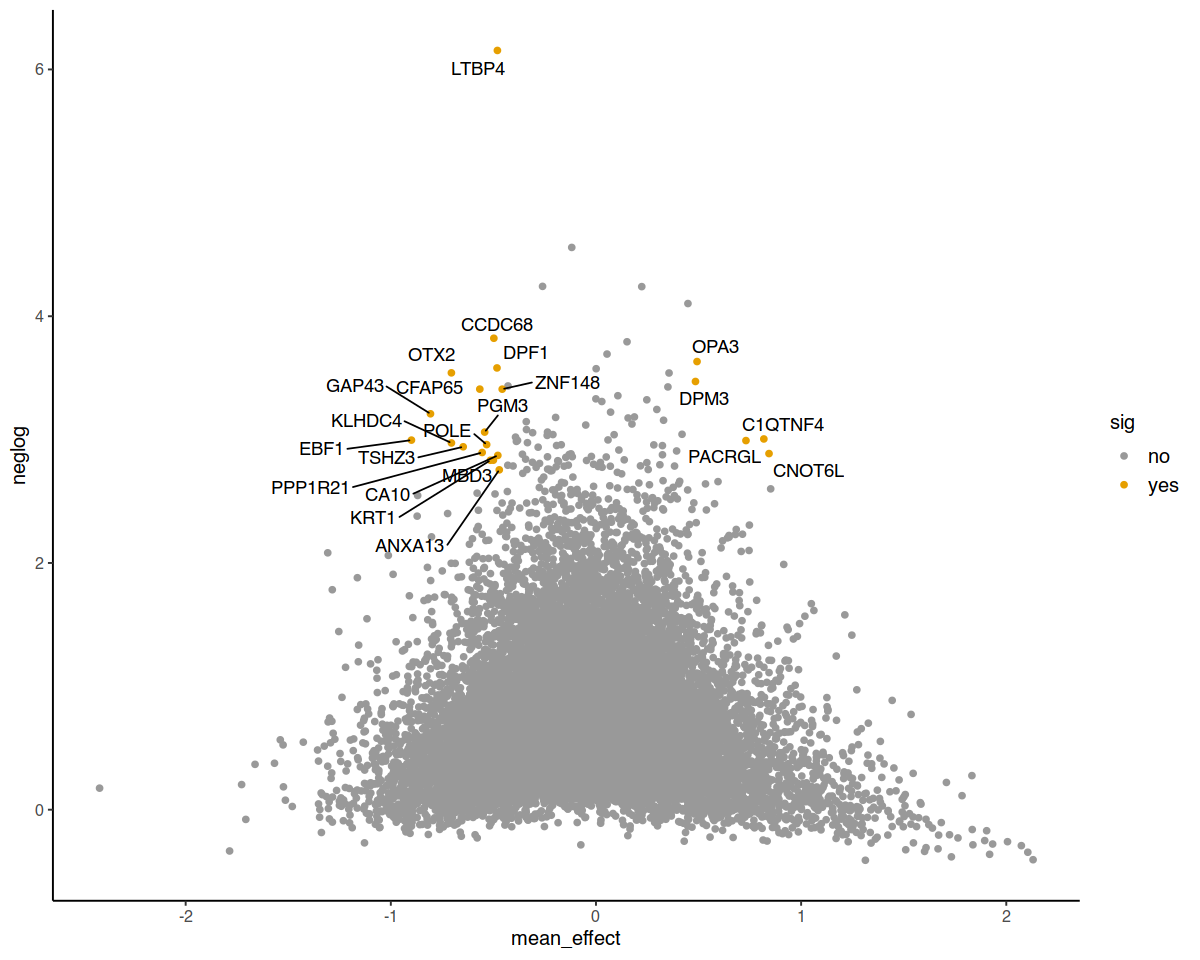

In [6]:
options(repr.plot.width=10, repr.plot.height=8)

plot_data <- delta_psi %>%
    mutate(mean_effect = mean(c(ko_1,ko_2))) %>%
    mutate(neglog = -log10(abs(ko_3))) %>%
    mutate(sig = ifelse(abs(mean_effect) > 0.45 & neglog > 2.7,"yes","no"))

plot_data %>% ggplot(aes(x = mean_effect, y = neglog, label = gene_symbol)) +
    geom_point(aes(color = sig)) + 
    geom_text_repel(aes(label = ifelse(sig == "yes", as.character(gene_symbol),"")), force = 10, max.overlaps = 100) + 
    NULL

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“The following aesthetics were dropped during statistical transformation: label
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor?”


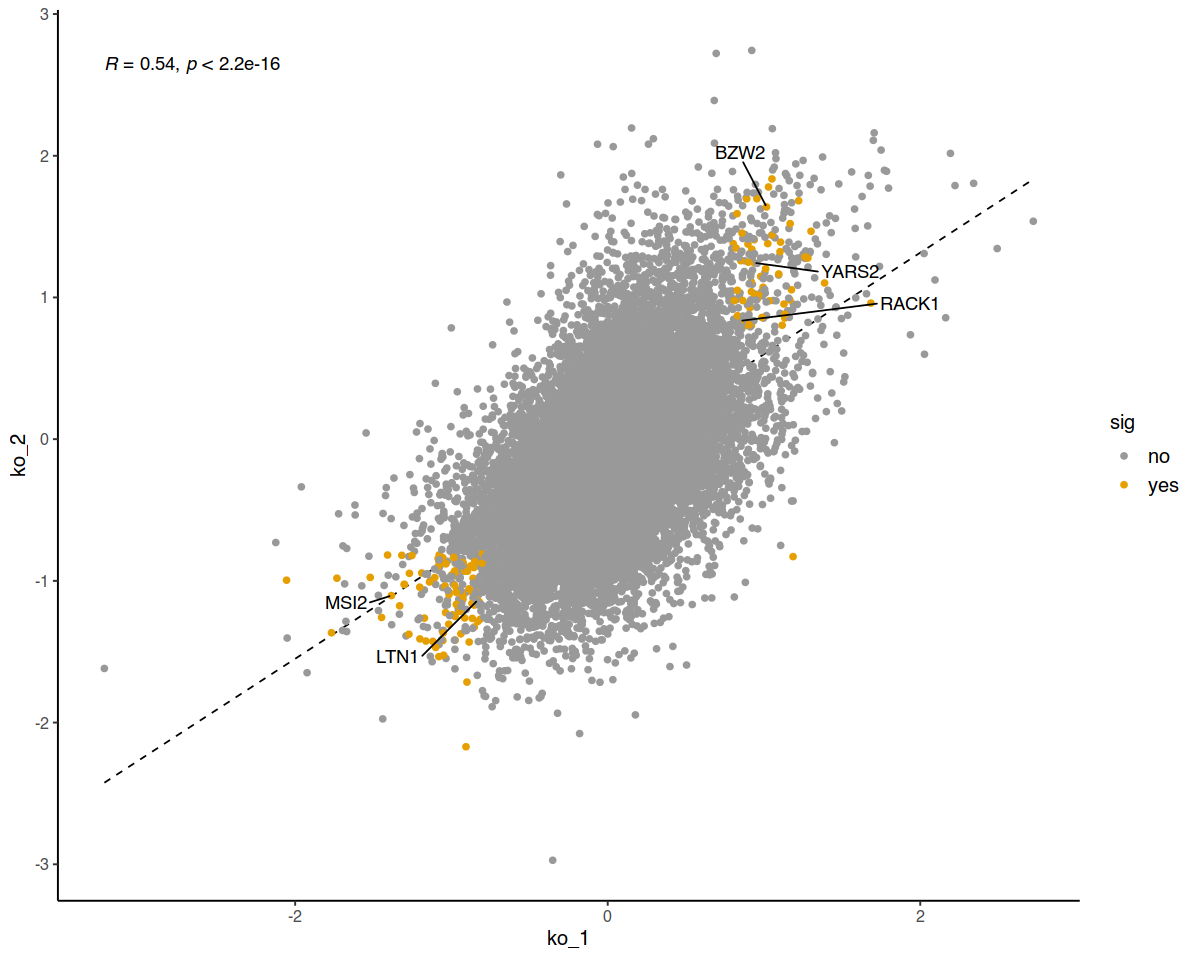

In [14]:
options(repr.plot.width=10, repr.plot.height=8)

plot_data <- delta_psi %>%
#    mutate(mean_effect = mean(c(ko_1,ko_2))) %>%
    mutate(neglog = -log10(abs(ko_3))) %>%
    mutate(sig = ifelse(abs(ko_1) > 0.8 & abs(ko_2) > 0.8 & neglog > 0.3,"yes","no"))

plot_data %>% ggplot(aes(x = ko_1, y = ko_2, label = gene_symbol)) +
    geom_smooth(aes(x = ko_1, y = ko_2), color = "black", size = 0.5, linetype = "dashed", se = FALSE, method = "lm") +
    geom_point(aes(color = sig)) +
    geom_text_repel(aes(label = ifelse(sig == "yes" & gene_symbol %in% trans$gene, as.character(gene_symbol),"")), force = 10, max.overlaps = 1000) + 
    stat_cor() +
    
    NULL

## Print table of N-termini _destabilized_ by UBR1
These are presumed to be UBR1 substrates with ∆PSI above 0.8

In [ ]:
delta_psi %>%
# filter to ∆PSI values > 0.8, per Timms et al.
    filter(ko_1 > 0.8) %>%
    filter(ko_2 > 0.8) %>%
# determine UBR1-specific effect by filtering absolute magnitude of KO 3
# (not sure how this was done in Timms et al., they mention a threshold of 0.6 for UBR specificity...)
    filter(abs(ko_3) < 0.6) %>%
# calculate mean stabilizing effect of clone 1 and clone 2 KO
    mutate(mean_effect = mean(c(ko_1,ko_2))) %>%
    arrange(desc(mean_effect)) %>%
# write table
    write_tsv("../../data/2024/ubr1_destabilized.tsv") %>%
    print()


## Print table of N-termini _stabilized_ by UBR1
These N-termini may be more stable in the presence of UBR1, for whatever reason

In [ ]:
delta_psi %>%
# filter to ∆PSI values > 0.8, per Timms et al.
    filter(ko_1 < -0.8) %>%
    filter(ko_2 < -0.8) %>%
# determine UBR1-specific effect by filtering absolute magnitude of KO 3
# (not sure how this was done in Timms et al.)
    filter(abs(ko_3) < 0.6) %>%
# calculate mean stabilizing effect of clone 1 and clone 2 KO
    mutate(mean_effect = mean(c(ko_1,ko_2))) %>%
    arrange(mean_effect) %>%
# write table
    write_tsv("../../data/2024/ubr1_stabilized.tsv") %>%
    print()
